## This notebook runs the Ring All Reduce (RAR) architecture _without_ validation partition of the data.

In [1]:
import os  # Operating system functionalities
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import pickle  # Serialization and deserialization of Python objects
import random as rn  # Random number generator
import itertools  # Functions for creating iterators for efficient looping
from IPython.display import display  # For rendering in Jupyter Notebook

from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.preprocessing import MinMaxScaler  # Scaling features to a range

from tensorflow.keras.models import Sequential # For linear stacking of layers
# For creating densely-connected neural network layers, dropout regularization, and normalizing inputs in layers:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2 # For penalizing large weights
from tensorflow.keras.optimizers import Adam # For efficient gradient descent optimization
from tensorflow.random import set_seed # To set global random seed in tensorflow

2024-02-09 11:49:33.148337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-09 11:49:33.289932: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Seeds to control randomness in the process.

In [2]:
np.random.seed(0)  # Setting the random seed for reproducibility
rn.seed(0)  # Setting the random seed for reproducibility
set_seed(0) # Setting the TensorFlow random seed for reproducibility

Loading processed and curated dataset:

In [3]:
dfHeart = pd.read_csv("/srv/heart_ConditionalMeanImputation.csv")
dfHeart

,Sex_F,Sex_M,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,40,140.0,289.0,0,172,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160.0,180.0,0,156,1.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,37,130.0,283.0,0,98,0.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48,138.0,214.0,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,54,150.0,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,45,110.0,264.0,0,132,1.2,1
914,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68,144.0,193.0,1,141,3.4,1
915,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,57,130.0,131.0,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,57,130.0,236.0,0,174,0.0,1


Assigning the name of the originating hospital to each point in the dataset.

In [4]:
dfHeart["Name"]="name"
# Estimated (from raw data) slices for each hospital
dfHeart.loc[0:293,"Name"] = "hung" # Hungarian Institute of Cardiology, Budapest
# Author: Andras Janosi, M.D.
dfHeart.loc[293:477,"Name"] = "swit" # University Hospital (Zurich and Basel) Switzerland
# Author: William Steinbrunn, M.D. and Matthias Pfisterer, M.D respectively.
dfHeart.loc[477:615,"Name"] = "long" # V.A. Medical Center, Long Beach
# Author: Robert Detrano, M.D., Ph.D.
dfHeart.loc[615:766,"Name"] = "stat" # Statlog dataset (confidential source)
# Author: "King RD. Department of Statistics and Modelling Science, University of Strathclyde, Glasgow"
dfHeart.loc[766:918,"Name"] = "clev" # Cleveland Clinic Foundation
# Author: Robert Detrano, M.D., Ph.D.

Creating different clients with the sliced data.

In [5]:
data_dict = {}

groups = dfHeart.groupby('Name')

for idx, group in enumerate(groups):
    X = group[1].drop(['HeartDisease', 'Name'], axis=1)
    y = group[1]['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    
    # Judith: escalamos los datos
    scaler = MinMaxScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    data_dict[idx] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

Building the optimal ANN architecture, previously estimated.

In [6]:
# Create the model
model = Sequential()

shape = data_dict[list(data_dict.keys())[0]]['X_train'].shape[1]

# Input layer
model.add(Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Hidden layers
model.add(Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(optimizer= Adam(learning_rate=0.001),
              loss="binary_crossentropy", 
              metrics=["accuracy", "AUC"])

2024-02-09 11:49:34.797697: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-02-09 11:49:34.797783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2024-02-09 11:49:34.798567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def ave_weights(n_i,listOfWeights):
    """
    Aggregation function

   :param list n_i: Number of samples for each client
   :param list listOfWeights: Weights for each client
   :return: Final weighted average for global model
    """
    N = sum(n_i) # total number of samples of all clients
    # initial weights of global model, set to zero
    ave_weights = listOfWeights[0]
    ave_weights = [i * 0 for i in ave_weights]
    # loop whose range is number of clients
    for j in range(len(n_i)):
        # receive weights from clients
        rec_weight = listOfWeights[j]
        # multiply the client weights by number of local data samples in client local data
        rec_weight =  [i * n_i[j] for i in rec_weight]
        # divide the weights by total number of samples of all clients
        rec_weight =  [i / N for i in rec_weight]
        # sum the weights of new client with the prior
        ave_weights = [x + y for x, y in zip(ave_weights,rec_weight)]
    return ave_weights

Ring all reduce architecture with 5 clients: [5,1,2,3,4] -> [1,2,3,4,5]

In [8]:
clients_send = list(range(1,len(data_dict)+1))
clients_send

[1, 2, 3, 4, 5]

In [9]:
clients = clients_send.copy()

In [10]:
clients.insert(0, clients.pop())
print(clients)

[5, 1, 2, 3, 4]


Initialization of empty lists. 

In [11]:
# To save metrics for test
acc_test_round = [[] for _ in range(len(clients))] 
loss_test_round = [[] for _ in range(len(clients))]
AUC_test_round = [[] for _ in range(len(clients))]
# To save client weights
save_weights = []

Running the rounds.

In [12]:
# Maximum number of rounds
n_times = 100
# weights_clients will save the weights for each client for a round
initial_weights = model.get_weights()
weights_clients = [[initial_weights] for _ in range(len(clients))]

for i in range(1,n_times+1):
    # Each round begins with one weight per client.
    for idx in range(len(clients)):
        # The model is trained with the weights ("initial_weights" in the first round or "avg_weights" later)
        model.set_weights(weights_clients[idx][0])
        X_train_np = np.array(data_dict[idx]['X_train'])
        y_train_np = np.array(data_dict[idx]['y_train'])
        history = model.fit(X_train_np,y_train_np, epochs=38, batch_size=14, verbose=0)
        
        # The new weights are added to the list stored at position i of weights_clients
        weights_clients[clients[idx]-1].append(model.get_weights())
    
        # Add those weights to a list stored in position 'j', 
        # where 'j' represents all the clients with whom client 'i' communicates
        weights_clients[clients_send[idx]-1].append(model.get_weights())
            
    # Now there are two sets of weights per position in weights_clients. 
    # weights_clients = [[weights_clients1, weights_clients5], [weights_clients2, weights_clients1], 
    # [weights_clients3, weights_clients2], [weights_clients4, weights_clients3],
    # [weights_clients5, weights_clients5]]
            
    # Averaging them will provide one set of weights again for each position in weights_clients.
    for idx in range(len(clients)):
        # Calculating the lengths
        samples_len = [len(data_dict[clients[idx]-1]['X_train']),len(data_dict[clients_send[idx]-1]['X_train'])]
        # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
        avg_weights = ave_weights(samples_len,weights_clients[idx]) # use of aggregation function
        weights_clients[idx] = [avg_weights]
        model.set_weights(avg_weights)
        X_test_np = np.array(data_dict[idx]['X_test'])
        y_test_np = np.array(data_dict[idx]['y_test'])
        score_test = model.evaluate(X_test_np, y_test_np, verbose = 0)
        # Saving metrics for test:
        loss_test_round[idx].append(score_test[0])
        acc_test_round[idx].append(score_test[1])
        AUC_test_round[idx].append(score_test[2])
    # Save actual weights of the client in a round    
    save_weights.append(weights_clients.copy())

Plotting the evolution (in rounds) of test metrics per client for the RAR architecture.

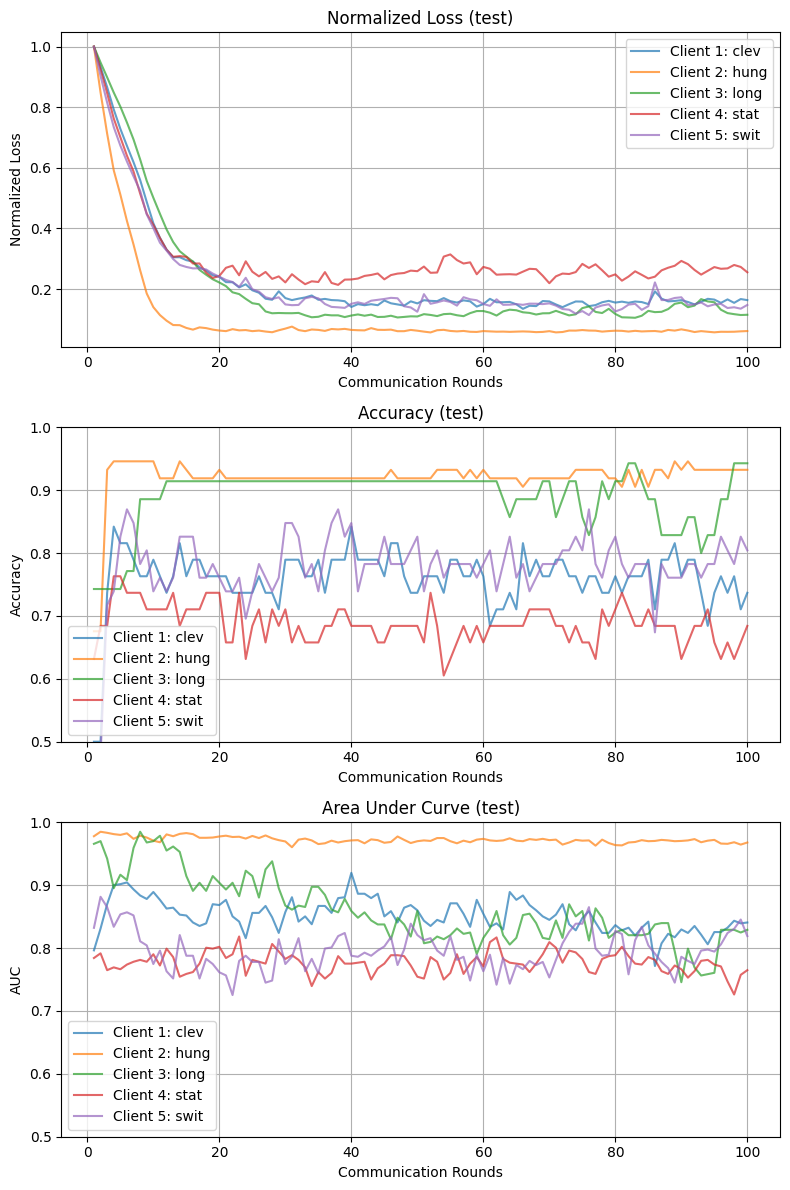

In [13]:
loss_test_round_np = np.array(loss_test_round)
# Create a figure with three subplots (one row and three columns)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 12))

# Iterate over the lists of loss, accuracy, and AUC of each client
for i, group in enumerate(groups):
    name = group[0]
    client_loss = loss_test_round_np[i]
    client_accuracy = acc_test_round[i]
    client_auc = AUC_test_round[i]
    
    # Subplot 1: Loss Curve
    ax1.plot(range(1, n_times + 1), client_loss / max(client_loss), label= f'Client {i+1}: {name}', alpha=0.7)

    # Subplot 2: Accuracy Curve
    ax2.plot(range(1, n_times + 1), client_accuracy, label= f'Client {i+1}: {name}', alpha=0.7)

    # Subplot 3: AUC Curve
    ax3.plot(range(1, n_times + 1), client_auc, label= f'Client {i+1}: {name}', alpha=0.7)

# Add labels and titles to subplots
ax1.set_xlabel('Communication Rounds')
ax1.set_ylabel('Normalized Loss')
ax1.set_title('Normalized Loss (test)')
#ax1.set(xlim=(0, 25))
ax1.grid()
ax1.legend()

ax2.set_xlabel('Communication Rounds')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy (test)')
# ax2.set(xlim=(0, 25))
ax2.set(ylim=(0.5, 1))
ax2.grid()
ax2.legend()

ax3.set_xlabel('Communication Rounds')
ax3.set_ylabel('AUC')
ax3.set_title('Area Under Curve (test)')
# ax3.set(xlim=(0, 25))
ax3.set(ylim=(0.5, 1))
ax3.grid()
ax3.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

Saving important lists for later analysis.

In [14]:
# Combine the lists of lists into a dictionary
data_to_save = {
    'acc_test_round': acc_test_round,
    'loss_test_round': loss_test_round,
    'AUC_test_round': AUC_test_round,
    'save_weights': save_weights
}

# Save the combined data using Pickle
with open('results_Test_RAR_v4.1_noValidation.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

Calculation of the weight divergence between pairs of clients for round 50, where loss metric converges.

In [19]:
def weight_divergence(weights_m, weights_n):
    """
    Compute the weight divergence between two sets of weights.

    :param list weights_m: Set of weights for model m
    :param list weights_n: Set of weights for model n
    :return: Weight divergence between the two sets of weights
    """
    # Flatten the weights arrays to 1-dimensional arrays
    flat_weights_m = np.concatenate([w.ravel() for w in weights_m])
    flat_weights_n = np.concatenate([w.ravel() for w in weights_n])

    # Compute the Euclidean norm of the difference between weights_m and weights_n
    norm_diff = np.linalg.norm(flat_weights_m - flat_weights_n)

    # Compute the Euclidean norm of weights_m and weights_n
    norm_m = np.linalg.norm(flat_weights_m)
    norm_n = np.linalg.norm(flat_weights_n)

    # Calculate the weight divergence
    divergence = norm_diff / (0.5 * (norm_m + norm_n))

    return divergence

In [20]:
# Calculate weight divergence for all combinations of pairs of clients
divergences = []
for pair in itertools.combinations(range(5), 2):
    client_a = pair[0]
    client_b = pair[1]
    divergence = weight_divergence(save_weights[49][client_a][0], save_weights[49][client_b][0])
    divergences.append({'Pair of Clients': f'{client_a + 1}-{client_b + 1}', 'Weight Divergence': divergence})

# Creating the table
divergences_df = pd.DataFrame(divergences)
divergences_df['Weight Divergence'] = divergences_df['Weight Divergence'].apply(lambda x: f'{x:.2f}')
divergences_df.index += 1
weight_divergence_table = divergences_df.style.set_caption('Weight Divergence in Round 50')

# Display the table
display(weight_divergence_table)

,Pair of Clients,Weight Divergence
1,1-2,0.79
2,1-3,0.56
3,1-4,0.48
4,1-5,0.02
5,2-3,0.88
6,2-4,0.88
7,2-5,0.79
8,3-4,0.51
9,3-5,0.56
10,4-5,0.48
